In [2]:
import pandas as pd
import seaborn as sns
import seaborn.apionly as sns

import numpy as np
sns.set(color_codes=True, font_scale=2, style="whitegrid", palette="muted")

import matplotlib.pyplot as plt
import pickle
%matplotlib inline

/Users/heytitle/projects/heatmapping-tutorial/venv/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


# No. flipping until prediction changed

In [3]:
def architecture_idx(a):
    if a == 's2':
        return 1
    elif a == 's3':
        return 2
    elif a =='deep_4l':
        return 3
    elif a == 'convdeep_4l':
        return 4

------- mnist : SEQ 1 --------
architecture              s2      s3  deep_4l  convdeep_4l
method                                                    
guided_backprop       3.0419  3.7064   3.9644       3.0261
lrp_deep_taylor       3.3513  3.0475   3.8442       3.0159
lrp_deep_taylor_f025  4.1138  3.0622   3.8734       2.9884
random                7.6425  7.6155   8.1445       8.7237
sensitivity           3.5936  3.6526   3.9390       3.1877
------- mnist : SEQ 4 --------
architecture              s2      s3  deep_4l  convdeep_4l
method                                                    
guided_backprop       4.6898  4.4534   4.9407       3.4629
lrp_deep_taylor       7.8061  3.6050   3.3560       3.6455
lrp_deep_taylor_f025  4.6504  3.5531   3.3455       3.2710
random                7.6523  8.2233   7.7192       8.4032
sensitivity           3.9174  4.1361   4.7847       3.8321
------- mnist : SEQ 7 --------
architecture              s2      s3  deep_4l  convdeep_4l
method                

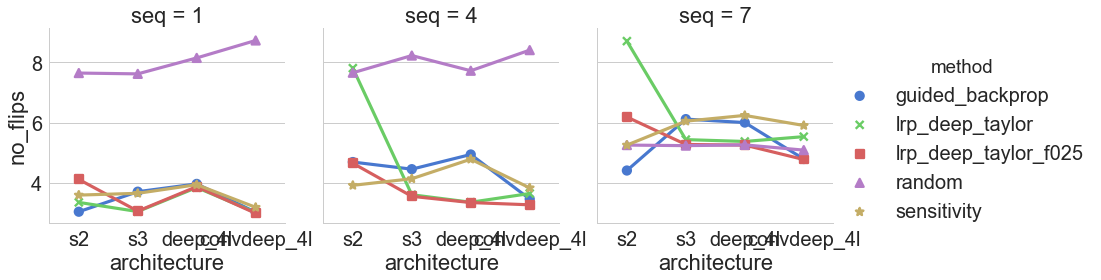

In [4]:
def read(stat, dataset, seqs=[1,4,7]):
    df = pd.read_csv('../stats/%s-%s.csv' % (stat, dataset))
        
    df['architecture_idx'] = df['architecture'].apply(architecture_idx)
    df = df.sort_values(by=['seq','architecture_idx', 'method'])

    sns.factorplot(x="architecture", y="no_flips", col='seq', hue="method", data=df, markers=['o', 'x', 's', '^', '*', 'p'])
    for i in seqs:
        d = df[df.seq == i].pivot( index='method', columns="architecture", values='no_flips')[['s2', 's3', 'deep_4l', 'convdeep_4l']]
        print('------- %s : SEQ %d --------' % (dataset, i))
        print(d)

read('no-flip', 'mnist')

------- fashion-mnist : SEQ 1 --------
architecture              s2      s3  deep_4l  convdeep_4l
method                                                    
guided_backprop       3.7520  3.6960   3.7725       4.9821
lrp_deep_taylor       4.0158  4.3223   4.3868       5.1275
lrp_deep_taylor_f025  4.6110  4.3415   4.4091       4.9800
lrp_deep_taylor_f050  4.3247  4.3333   4.3991       5.0236
random                5.7957  6.0409   6.3051       8.5569
sensitivity           3.9968  3.6976   3.7626       5.6941
------- fashion-mnist : SEQ 4 --------
architecture              s2      s3  deep_4l  convdeep_4l
method                                                    
guided_backprop       6.4540  4.5381   5.7973       4.1795
lrp_deep_taylor       7.5502  4.4362   5.2792       4.9524
lrp_deep_taylor_f025  7.2478  4.2989   5.2705       4.1041
lrp_deep_taylor_f050  7.5298  4.3367   5.2848       4.3510
random                6.4923  6.0664   6.8023       7.4029
sensitivity           5.4877  3.9984 

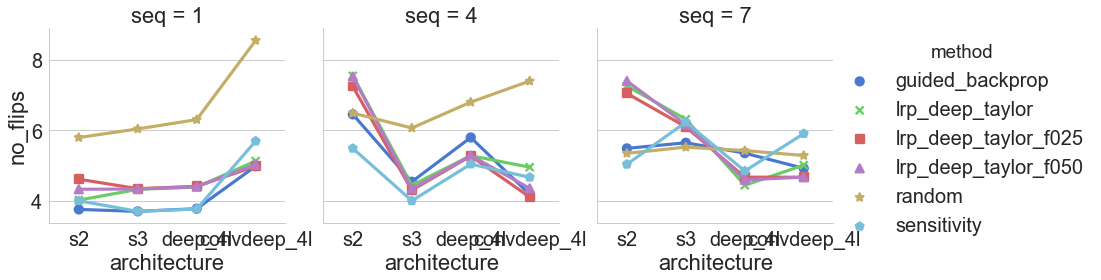

In [4]:
read('no-flip', 'fashion-mnist')

# AUC

In [11]:
def get_auc_relative_conv(datasets, flip_function = 'minus_one', base=''):
    results = []
    for dataset in datasets :
        file = "../stats/%s-%s-using-%s-flip.pkl" %(base, dataset, flip_function)
        print('getting data from %s' % file)
        results = results + pickle.load(open(file, "rb"))
        
    rel_at_k = []
    total_k = len(results[0]['avg_relevance_at_k'])
    for r in results:    
        for i, rel in zip(range(total_k), r['avg_relevance_at_k']):
            d = dict(**r)
            d['k'] = i
            d['relevance'] = rel
            del d['avg_relevance_at_k']

            rel_at_k.append(d)
            
    df_min_rel_at_k = pd.DataFrame(rel_at_k).groupby(['dataset', 'seq', 'architecture'])['relevance'].min()\
        .reset_index().rename(columns={'relevance': 'min_rel'})
    
    df = pd.DataFrame(results).merge(df_min_rel_at_k, how='left', on=['dataset', 'seq', 'architecture'])

    def compute_auc(row):
        rels = row['avg_relevance_at_k'] 
        return np.trapz(rels)

    df['auc'] = df.apply(compute_auc, axis=1)
    df['architecture_idx'] = df['architecture'].apply(architecture_idx)
    

    def normalize_auc(row):
#         auc_random = df[(df.dataset == row['dataset']) & (df.architecture == row['architecture']) & (df.seq == row['seq']) & (df.method == 'random')]['auc']

        return row['auc']

    df['auc_derived_from_rel_conv_seq1'] = df.apply(normalize_auc, axis=1)

    g = sns.factorplot(x="architecture_idx", y="auc_derived_from_rel_conv_seq1", row='seq', col='dataset', hue="method",
                       data=df,  size=5, markers=['*', '.', '.', 's', 'o', 'o', '^'], linestyles=[':', ':', ':', ':', '-', '-', '-'])

    g.set_xticklabels(['Shallow', 'Deep', 'DeepV2', 'ConvDeep'], rotation=30)

    
get_auc_relative_conv(['mnist', 'fashion-mnist'], base='auc-relative-conv-seq-same')

getting data from ../stats/auc-relative-conv-seq-same-mnist-using-minus_one-flip.pkl


FileNotFoundError: [Errno 2] No such file or directory: '../stats/auc-relative-conv-seq-same-mnist-using-minus_one-flip.pkl'

In [12]:
get_auc_relative_conv(['mnist', 'fashion-mnist'], base='auc-relative-conv')

getting data from ../stats/auc-relative-conv-mnist-using-minus_one-flip.pkl


FileNotFoundError: [Errno 2] No such file or directory: '../stats/auc-relative-conv-mnist-using-minus_one-flip.pkl'

In [13]:
get_auc_relative_conv(['mnist', 'fashion-mnist'], base='auc-relative-conv')

getting data from ../stats/auc-relative-conv-mnist-using-minus_one-flip.pkl


FileNotFoundError: [Errno 2] No such file or directory: '../stats/auc-relative-conv-mnist-using-minus_one-flip.pkl'

# Relevance Distribution

getting data from ../stats/rel-dist-mnist-3-digits.pkl
getting data from ../stats/rel-dist-fashion-mnist-3-items.pkl


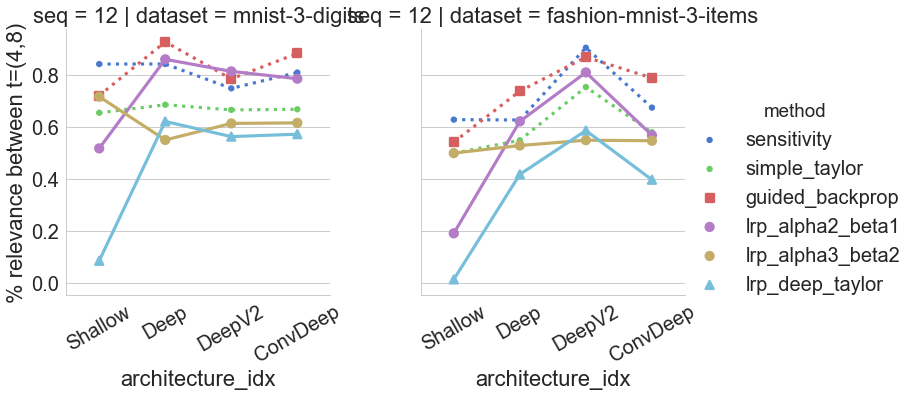

In [11]:
def plot_relevance_dist_at_between_timestep(datasets=['mnist-3-digits'], between=(4,8)):
    results = []
    for dataset in datasets :
        file = "../stats/rel-dist-%s.pkl" %(dataset)
        print('getting data from %s' % file)
        results = results + pickle.load(open(file, "rb"))
        
    df = pd.DataFrame(results)
    def compute_dist(row):

        return np.sum(row['rel_dist'][between[0]:between[1]])
    
    df['architecture_idx'] = df['architecture'].apply(architecture_idx)

    col_name = '%% relevance between t=(%d,%d)' % between
    df[col_name] = df.apply(compute_dist, axis=1)
    
    g = sns.factorplot(x="architecture_idx", y=col_name, row='seq', col='dataset', hue="method",
                   data=df,  size=5, markers=['.', '.', 's', 'o', 'o', '^'], linestyles=[ ':', ':', ':', '-', '-', '-'])
    
    g.set_xticklabels(['Shallow', 'Deep', 'DeepV2', 'ConvDeep'], rotation=30)


   
plot_relevance_dist_at_between_timestep(['mnist-3-digits', 'fashion-mnist-3-items'])

getting data from ../stats/rel-dist-mnist-3-digits.pkl
getting data from ../stats/rel-dist-fashion-mnist-3-items.pkl


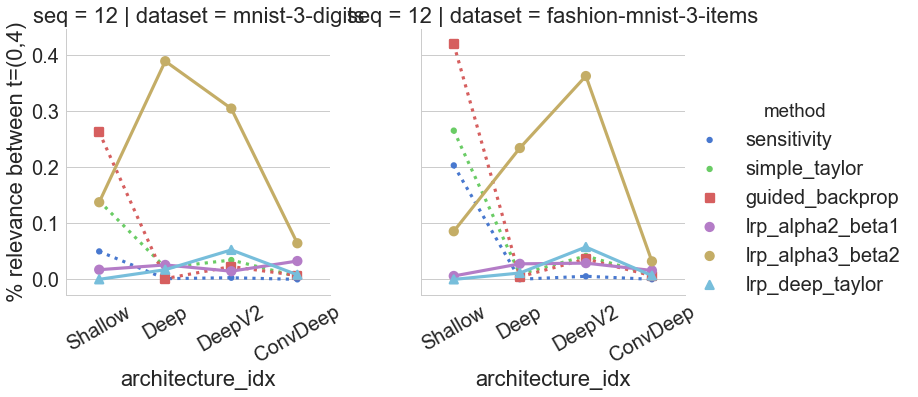

In [12]:
plot_relevance_dist_at_between_timestep(['mnist-3-digits', 'fashion-mnist-3-items'], between=(0,4))

getting data from ../stats/rel-dist-mnist-3-digits.pkl
getting data from ../stats/rel-dist-fashion-mnist-3-items.pkl


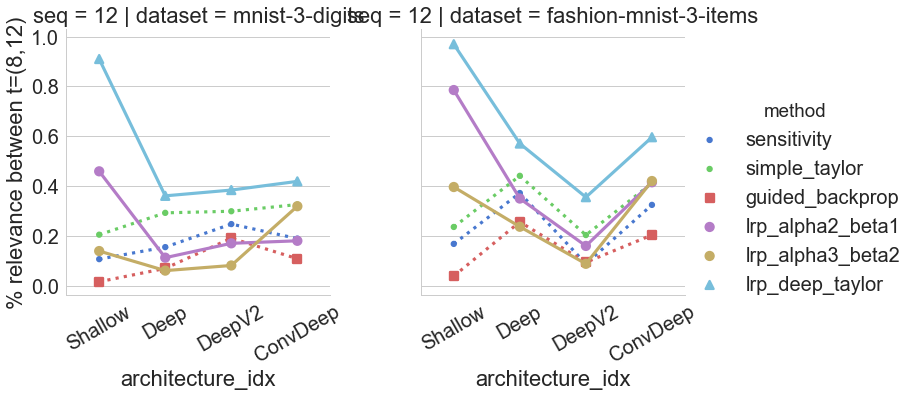

In [15]:
plot_relevance_dist_at_between_timestep(['mnist-3-digits', 'fashion-mnist-3-items'], between=(8,12))